### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > Spaceship Titanic<br><div>

####  ***Machine Learning Model implemented by: Víctor E. Núnez***

For this project I will be using pySpark as a practice and learning mode.

#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > TABLE OF CONTENTS<br><div>

* [LIBRARIES](#1)
* [LOAD DATA](#2)
* [PROCESSING](#3)
  * [Categorical variables](#3.1)
  * [Numerical variables](#3.2)
  * [Encoding Categoricals](#3.3)
* [DATA ANALYSIS](#4)
* [MODEL SELECTION](#5)
  * [Hyper-parameter search](#5.1)
  * [Training and Learning Curve](#5.1) 
* [PREDITIONS AND SUBMISSION](#6)


<a id="1"></a>
##### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > LIBRARIES<br><div>

In [1]:
%%time
from warnings import filterwarnings
filterwarnings('ignore')
from gc import collect

import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

CPU times: user 1.91 s, sys: 263 ms, total: 2.17 s
Wall time: 2.09 s


In [2]:
#PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, sum, split, when, avg, sum
from pyspark.sql.types import StructType, StructField, FloatType

#ML
from pyspark.ml.feature import StringIndexer
from pycaret.classification import setup, compare_models

from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
%%time
spark = SparkSession.builder.appName('spaceshiptitanic').getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/17 20:06:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


CPU times: user 47.3 ms, sys: 45.2 ms, total: 92.5 ms
Wall time: 10.1 s


<a id="2"></a>
##### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > LOAD DATA<br><div>

In [4]:
%%time
train = spark.read.csv('train.csv', header=True, inferSchema=True)
test  = spark.read.csv('test.csv', header=True, inferSchema= True)

collect();

CPU times: user 194 ms, sys: 27.7 ms, total: 221 ms
Wall time: 13.7 s


In [5]:
%%time
#Target
target = train.select('Transported')

# Name is not a required variable.
train_0 = train.drop('Transported', 'Name')
test_0 = test.drop('Name')

#Combine Train and Test Sets
data_0 = train_0.union(test_0)

collect();

CPU times: user 153 ms, sys: 4.12 ms, total: 157 ms
Wall time: 341 ms


In [6]:
data_0.columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

<a id="3"></a>
##### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > PROCESSING<br><div>

In [7]:
data_0.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- HomePlanet: string (nullable = true)
 |-- CryoSleep: boolean (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- VIP: boolean (nullable = true)
 |-- RoomService: double (nullable = true)
 |-- FoodCourt: double (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- Spa: double (nullable = true)
 |-- VRDeck: double (nullable = true)



<a id="3.1"></a>
###### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > Categorical variables<br><div>

- #### PassengerId

In [8]:
data_0.select('PassengerId').show(5)

+-----------+
|PassengerId|
+-----------+
|    0001_01|
|    0002_01|
|    0003_01|
|    0003_02|
|    0004_01|
+-----------+
only showing top 5 rows



In [9]:
#Split
data_0 =  data_0.withColumn('Group', split(data_0['PassengerId'],'_').getItem(0))\
                .withColumn('GroupNum', split(data_0['PassengerId'],'_').getItem(1))

data_0 =  data_0.drop('PassengerId')

In [10]:
%%time
print(data_0.select('Group').distinct().count())
print(data_0.select('GroupNum').distinct().count())

9280
8
CPU times: user 20.6 ms, sys: 4.06 ms, total: 24.6 ms
Wall time: 6.63 s


In [11]:
#Group contains too many unique values to be categorized, we are removing this column.
data_0 =  data_0.drop('Group')

- #### HomePlanet

In [12]:
%%time
data_0.groupBy('HomePlanet').count().show()

+----------+-----+
|HomePlanet|count|
+----------+-----+
|      NULL|  288|
|      Mars| 2684|
|     Earth| 6865|
|    Europa| 3133|
+----------+-----+

CPU times: user 170 µs, sys: 7.52 ms, total: 7.69 ms
Wall time: 1.63 s


In [13]:
#Impute using the column mode
data_0 = data_0.fillna('Earth', subset = ['Homeplanet'])

#### Cabin

In [14]:
%%time
data_0.select('Cabin').show(5)

+-----+
|Cabin|
+-----+
|B/0/P|
|F/0/S|
|A/0/S|
|A/0/S|
|F/1/S|
+-----+
only showing top 5 rows

CPU times: user 8.35 ms, sys: 3.03 ms, total: 11.4 ms
Wall time: 1.59 s


In [15]:
#Split 
data_0 = data_0.withColumn('Deck', split(data_0['Cabin'],'/').getItem(0))\
               .withColumn('Num', split(data_0['Cabin'],'/').getItem(1))\
               .withColumn('Side', split(data_0['Cabin'],'/').getItem(2))

data_0 =  data_0.drop('Cabin')

In [16]:
data_0.groupBy('Deck').count().show()

+----+-----+
|Deck|count|
+----+-----+
|   F| 4239|
|NULL|  299|
|   E| 1323|
|   T|   11|
|   B| 1141|
|   D|  720|
|   C| 1102|
|   A|  354|
|   G| 3781|
+----+-----+



In [17]:
data_0.groupBy('Num').count().orderBy(col('count').desc()).show(5)

+----+-----+
| Num|count|
+----+-----+
|NULL|  299|
|  82|   34|
|  56|   28|
|   4|   28|
|  95|   27|
+----+-----+
only showing top 5 rows



In [18]:
data_0.groupby('Side').count().show()

+----+-----+
|Side|count|
+----+-----+
|NULL|  299|
|   S| 6381|
|   P| 6290|
+----+-----+



In [19]:
#Impute using the column mode
data_0 =  data_0.fillna('F', subset=['Deck'])
data_0 =  data_0.fillna('82', subset=['Num'])
data_0 =  data_0.fillna('P', subset=['Side']) 

- #### Destination

In [20]:
data_0.groupby('Destination').count().show()

+-------------+-----+
|  Destination|count|
+-------------+-----+
|PSO J318.5-22| 1184|
|         NULL|  274|
|  TRAPPIST-1e| 8871|
|  55 Cancri e| 2641|
+-------------+-----+



In [21]:
data_0 =  data_0.fillna('TRAPPIST-1e', subset=['Destination'])

- #### CryoSleep/VIP

In [22]:
data_0.groupby('CryoSleep').count().show(); data_0.groupby('VIP').count().show()

+---------+-----+
|CryoSleep|count|
+---------+-----+
|     NULL|  310|
|     true| 4581|
|    false| 8079|
+---------+-----+

+-----+-----+
|  VIP|count|
+-----+-----+
| NULL|  296|
| true|  273|
|false|12401|
+-----+-----+



In [23]:
data_0 = data_0.fillna(False, subset=['CryoSleep'])
data_0 = data_0.fillna(False, subset=['VIP'])

In [24]:
data_1 =  data_0

<a id="3.2"></a>
###### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > Numerical variables <br><div>

In [25]:
data_1.printSchema()

root
 |-- HomePlanet: string (nullable = false)
 |-- CryoSleep: boolean (nullable = false)
 |-- Destination: string (nullable = false)
 |-- Age: double (nullable = true)
 |-- VIP: boolean (nullable = false)
 |-- RoomService: double (nullable = true)
 |-- FoodCourt: double (nullable = true)
 |-- ShoppingMall: double (nullable = true)
 |-- Spa: double (nullable = true)
 |-- VRDeck: double (nullable = true)
 |-- GroupNum: string (nullable = true)
 |-- Deck: string (nullable = false)
 |-- Num: string (nullable = false)
 |-- Side: string (nullable = false)



- #### CryoSleep

In [26]:
data_1.groupby('CryoSleep').count().show()

+---------+-----+
|CryoSleep|count|
+---------+-----+
|     true| 4581|
|    false| 8389|
+---------+-----+



In [27]:
data_1=  data_1.fillna(False,subset=['CryoSleep'])

- #### Age

<Figure size 800x550 with 0 Axes>

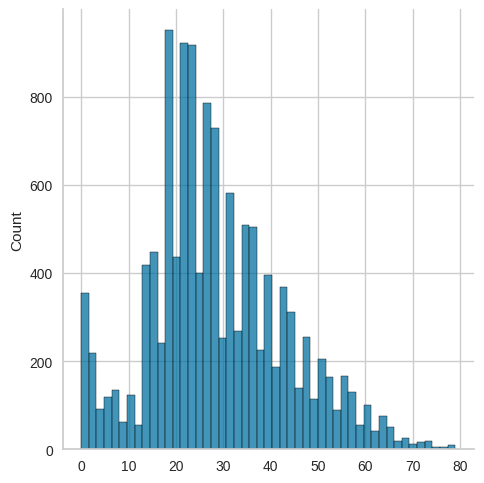

In [28]:
plt.figure()
sns.displot([row.Age for row in data_1.select('Age').collect()])

In [29]:
#Impute using mean value
mean = round((data_1.select(avg(col('Age'))).collect()[0][0]))

data_1 =  data_1.fillna(mean, subset=['Age'])

In [30]:
#0-10 : A
#11-20: B
#21-40: C
#41-60: D
#60+  : E


data_1 = data_1.withColumn('Category', 
                  when(col('Age').between(0,10), 'A').
                  when(col('Age').between(11,20), 'B').
                  when(col('Age').between(21,40), 'C').
                  when(col('Age').between(41,60), 'D').
                  when(col('Age')>60, 'E')
                 )

data_1 =  data_1.drop('Age')

- #### RoomService
- #### FoodCourt
- #### ShoppingMall
- #### Spa 
- #### VRDeck

In [31]:
#Impute using mean value
data_1 = data_1.fillna(round(data_1.select(avg(col('RoomService'))).collect()[0][0]), subset=['RoomService'])
data_1 = data_1.fillna(round(data_1.select(avg(col('FoodCourt'))).collect()[0][0]), subset=['FoodCourt'])
data_1 = data_1.fillna(round(data_1.select(avg(col('ShoppingMall'))).collect()[0][0]), subset=['ShoppingMall'])
data_1 = data_1.fillna(round(data_1.select(avg(col('Spa'))).collect()[0][0]), subset=['Spa'])
data_1 = data_1.fillna(round(data_1.select(avg(col('VRDeck'))).collect()[0][0]), subset=['VRDeck'])

In [32]:
data_2 =  data_1

<a id="3.3"></a>
###### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > Encoding Catecoricals<br><div>

In [33]:
data_2.printSchema()

root
 |-- HomePlanet: string (nullable = false)
 |-- CryoSleep: boolean (nullable = false)
 |-- Destination: string (nullable = false)
 |-- VIP: boolean (nullable = false)
 |-- RoomService: double (nullable = false)
 |-- FoodCourt: double (nullable = false)
 |-- ShoppingMall: double (nullable = false)
 |-- Spa: double (nullable = false)
 |-- VRDeck: double (nullable = false)
 |-- GroupNum: string (nullable = true)
 |-- Deck: string (nullable = false)
 |-- Num: string (nullable = false)
 |-- Side: string (nullable = false)
 |-- Category: string (nullable = true)



In [34]:
cols_str = [cols for cols in data_2.columns if data_2.select(cols).dtypes[0][1] ==  'string']
cols_str

['HomePlanet', 'Destination', 'GroupNum', 'Deck', 'Num', 'Side', 'Category']

In [35]:
encoders = {}

for col_ in cols_str:
    encoder = StringIndexer(inputCol= col_, outputCol=col_+'_enc')
    encoders[col_] = encoder.fit(data_2)
    data_2 = encoders[col_].transform(data_2)

for col_ in cols_str:
    data_2 =  data_2.drop(col_)

In [36]:
data_2 =  data_2.withColumn('CryoSleep', col('CryoSleep').cast('int'))\
                .withColumn('VIP', col('VIP').cast('int'))

target = target.withColumn('Transported', col('Transported').cast('int'))


In [37]:
data_3 =  data_2

In [38]:
# Final Split
data_3 = data_3.withColumn('Index',monotonically_increasing_id())

train_final = data_3.select('*').where(col('Index')<=target.count())
train_final =  train_final.drop('Index')

test_final = data_3.select('*').where(col('Index')>target.count())
test_final = test_final.drop('Index')

<a id="4"></a>
##### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > DATA ANALYSIS<br><div>

In [39]:
train_final.printSchema()

root
 |-- CryoSleep: integer (nullable = false)
 |-- VIP: integer (nullable = false)
 |-- RoomService: double (nullable = false)
 |-- FoodCourt: double (nullable = false)
 |-- ShoppingMall: double (nullable = false)
 |-- Spa: double (nullable = false)
 |-- VRDeck: double (nullable = false)
 |-- HomePlanet_enc: double (nullable = false)
 |-- Destination_enc: double (nullable = false)
 |-- GroupNum_enc: double (nullable = false)
 |-- Deck_enc: double (nullable = false)
 |-- Num_enc: double (nullable = false)
 |-- Side_enc: double (nullable = false)
 |-- Category_enc: double (nullable = false)



- #### CryoSleep and VIP

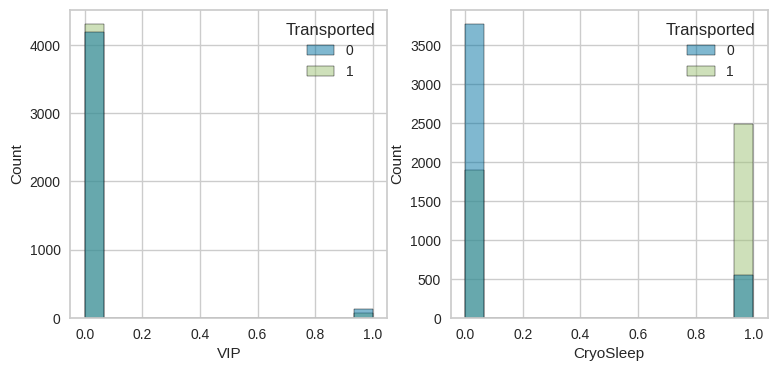

In [40]:
pd_target = target.select('Transported').toPandas()
feature_CryoSleep =  train_final.select('CryoSleep').toPandas()
feature_VIP =  train_final.select('VIP').toPandas()

plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
sns.histplot(x = feature_VIP['VIP'] ,
             hue = pd_target['Transported'])
plt.xlabel('VIP')

plt.subplot(1,2,2)
sns.histplot(x = feature_CryoSleep['CryoSleep'] ,
             hue = pd_target['Transported'])
plt.xlabel('CryoSleep')
plt.show()

- #### RoomService
- #### FoodCourt
- #### ShoppingMall
- #### Spa 
- #### VRDeck

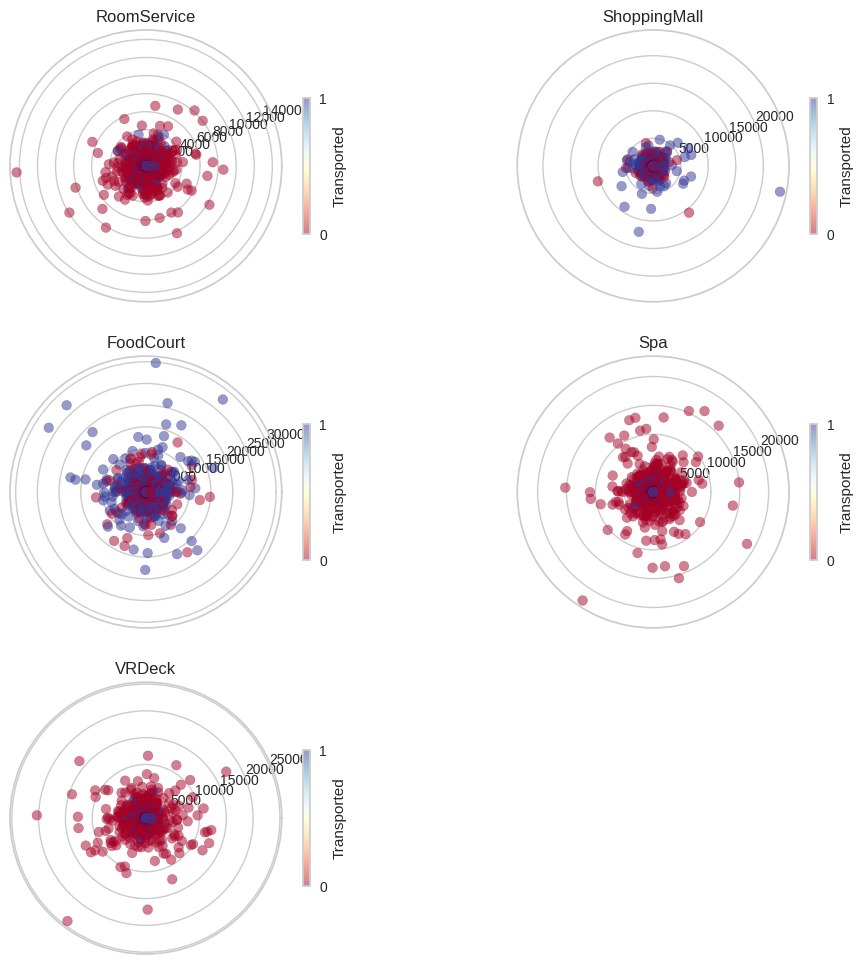

In [41]:
feature_RoomService = train_final.select('RoomService').toPandas()
feature_ShoppingMall = train_final.select('ShoppingMall').toPandas()
feature_FoodCourt = train_final.select('FoodCourt').toPandas()
feature_Spa = train_final.select('Spa').toPandas()
feature_VRDeck = train_final.select('VRDeck').toPandas()

angle = np.linspace(0,2*np.pi, len(feature_RoomService), endpoint=False).tolist()

plt.figure(figsize=(12,12))

plt.subplot(321,polar =  True)
plt.xticks([])
plt.title('RoomService')
plt.scatter(angle, 
            feature_RoomService['RoomService'].tolist(), 
            c = pd_target['Transported'].tolist(),
            cmap=plt.cm.RdYlBu,
            alpha=0.5
           )

plt.colorbar( label = 'Transported', shrink = 0.5, ticks = [0,1], aspect = 20)


plt.subplot(322,polar =  True)
plt.xticks([])
plt.title('ShoppingMall')
plt.scatter(angle, 
            feature_ShoppingMall['ShoppingMall'].tolist(), 
            c = pd_target['Transported'].tolist(),
            cmap=plt.cm.RdYlBu,
            alpha=0.5
           )
plt.colorbar( label = 'Transported', shrink = 0.5, ticks = [0,1], aspect = 20)

plt.subplot(323,polar =  True)
plt.xticks([])
plt.title('FoodCourt')
plt.scatter(angle, 
            feature_FoodCourt['FoodCourt'].tolist(), 
            c = pd_target['Transported'].tolist(),
            cmap=plt.cm.RdYlBu,
            alpha=0.5
           )
plt.colorbar( label = 'Transported', shrink = 0.5, ticks = [0,1], aspect = 20)

plt.subplot(324,polar =  True)
plt.xticks([])
plt.title('Spa')
plt.scatter(angle, 
            feature_Spa['Spa'].tolist(), 
            c = pd_target['Transported'].tolist(),
            cmap=plt.cm.RdYlBu,
            alpha=0.5
           )
plt.colorbar( label = 'Transported', shrink = 0.5, ticks = [0,1], aspect = 20)

plt.subplot(325,polar =  True)
plt.xticks([])
plt.title('VRDeck')
plt.scatter(angle, 
            feature_VRDeck['VRDeck'].tolist(), 
            c = pd_target['Transported'].tolist(),
            cmap=plt.cm.RdYlBu,
            alpha=0.5
           )

plt.colorbar( label = 'Transported', shrink = 0.5, ticks = [0,1], aspect = 20)
plt.show()

In [42]:
# Remove ShoopingMall and FoodCourt
train_final =  train_final.drop('ShoppingMall','FoodCourt')
test_final =  test_final.drop('ShoppingMall','FoodCourt')

In [43]:
#We switch to pandas at this point.
train_final =  train_final.toPandas()
test_final  = test_final.toPandas() 
target = target.toPandas()
target =  target.Transported

<a id="5"></a>
##### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > SELECCIÓN DE MODELO<br><div>

In [44]:
#%%time
#setup(data = pd.concat([train_final, target], axis = 1), target = 'Transported')
#compare_models()

#collect();

<a id="5.1"></a>
###### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > Hyper-parameter search<br><div>

In [45]:
%%time
param_grid = {'max_depth': [5],
              'learning_rate':[0.01,0.1,0.2],
              'max_features':[8,10,12,14]
              }

gbc_model = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring="accuracy", cv=5)
gbc_model.fit(train_final, target)
gbc_params = gbc_model.best_params_
print("Best score = %f, Best parameters = %s" % (1. - gbc_model.best_score_, gbc_model.best_params_))

collect();

Best score = 0.217989, Best parameters = {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 8}
CPU times: user 4min 7s, sys: 1.19 s, total: 4min 8s
Wall time: 4min 10s


<a id="5.2"></a>
###### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > Training and Learning Curve<br><div>

In [46]:
gbc_params['random_state'] = 42

gbc_model =  GradientBoostingClassifier()
gbc_model.fit(train_final, target)

print('Score = {}'.format(gbc_model.score(train_final,target)))

Score = 0.8059358104221788


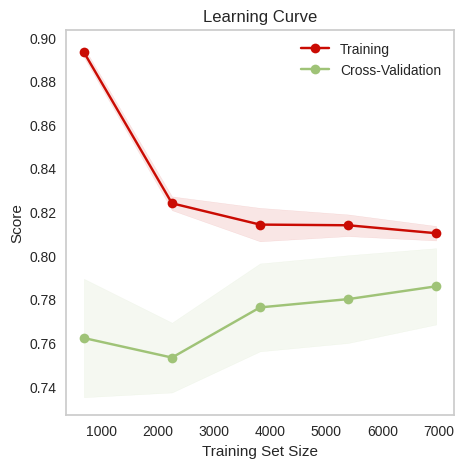

In [47]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(5, 5))
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation")
    
    plt.legend(loc="best")
    plt.show()

# Use the plot_learning_curve function passing your estimator (model), X (training data), and y (training labels)
plot_learning_curve(gbc_model, train_final, target)

In [48]:
#The curve doesn't look very good, it can be improved ;)

<a id="6"></a>
##### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:180%; text-align:left;padding:3.0px; background: white; border-bottom: 8px solid #0047b3" > PREDICTIONS AND SUBMISSION<br><div>

In [49]:
PassengerId =  test.select('PassengerId').toPandas()
final_predictions = gbc_model.predict(test_final)
final_predictions = final_predictions.astype(bool)
submission = pd.concat([PassengerId, pd.Series(final_predictions, name = 'Transported')], axis= 1)
submission.to_csv('./submission_predictions.csv',index=False, header= True)